# X-ADX 趋势因子回测测试

测试改良版 ADX (X-ADX) 趋势因子，使用 Mark-to-Market 回测系统


In [1]:
# 导入库和设置路径
import sys
from pathlib import Path
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# 设置 matplotlib 支持中文显示
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# 添加项目根目录到路径
project_root = Path().resolve().parent.parent
sys.path.append(str(project_root))

# 重新加载模块（确保使用最新代码）
import importlib
if 'research.factors.x_adx' in sys.modules:
    importlib.reload(sys.modules['research.factors.x_adx'])
if 'research.backtest.signals' in sys.modules:
    importlib.reload(sys.modules['research.backtest.signals'])
if 'research.backtest.portfolio_bt' in sys.modules:
    importlib.reload(sys.modules['research.backtest.portfolio_bt'])
if 'research.backtest.factor_test' in sys.modules:
    importlib.reload(sys.modules['research.backtest.factor_test'])

# 导入项目模块
from research.factors.x_adx import XADXFactor
from research.backtest.signals import normalize_factor, normalize_positions
from research.backtest.portfolio_bt import simulate_portfolio, calculate_metrics, load_costs_config, load_backtest_config, create_synthetic_benchmark
from research.backtest.factor_test import factor_returns_by_quantile, calculate_ic, calculate_ir, plot_ic_distribution

print("✓ 所有模块导入成功！")
print(f"项目根目录: {project_root}")


✓ 所有模块导入成功！
项目根目录: C:\Users\Chengyu Gong\Klpha\KlphaOriginal


## 步骤 1: 加载数据


In [2]:
# 加载数据
data_path = project_root / "data" / "processed" / "data.pkl"

print(f"加载数据: {data_path}")
with open(data_path, 'rb') as f:
    data = pickle.load(f)

print(f"\n数据包含的字段: {list(data.keys())}")
print(f"\n数据统计:")
for key, df in data.items():
    if isinstance(df, pd.DataFrame):
        print(f"  {key}: {df.shape[0]} 行 × {df.shape[1]} 列")
        print(f"    日期范围: {df.index.min()} 到 {df.index.max()}")

# 创建合成基准（等权重组合），消除幸存者偏差
print(f"\n创建合成基准（等权重组合）...")
synthetic_benchmark = create_synthetic_benchmark(data['close'])
print(f"  合成基准数据: {len(synthetic_benchmark)} 个交易日")
print(f"  日期范围: {synthetic_benchmark.index.min()} 到 {synthetic_benchmark.index.max()}")
print(f"  说明: 基于当前股票池构建等权重指数，确保基准和策略使用相同的股票池")


加载数据: C:\Users\Chengyu Gong\Klpha\KlphaOriginal\data\processed\data.pkl

数据包含的字段: ['close', 'open', 'high', 'low', 'volume']

数据统计:
  close: 2763 行 × 501 列
    日期范围: 2015-01-02 00:00:00-05:00 到 2025-12-26 00:00:00-05:00
  open: 2763 行 × 501 列
    日期范围: 2015-01-02 00:00:00-05:00 到 2025-12-26 00:00:00-05:00
  high: 2763 行 × 501 列
    日期范围: 2015-01-02 00:00:00-05:00 到 2025-12-26 00:00:00-05:00
  low: 2763 行 × 501 列
    日期范围: 2015-01-02 00:00:00-05:00 到 2025-12-26 00:00:00-05:00
  volume: 2763 行 × 501 列
    日期范围: 2015-01-02 00:00:00-05:00 到 2025-12-26 00:00:00-05:00

创建合成基准（等权重组合）...
  合成基准数据: 2762 个交易日
  日期范围: 2015-01-05 00:00:00-05:00 到 2025-12-26 00:00:00-05:00
  说明: 基于当前股票池构建等权重指数，确保基准和策略使用相同的股票池


## 步骤 2: 计算 X-ADX 因子


In [3]:
# 计算 X-ADX 因子
print("计算 X-ADX 因子")

# 创建 X-ADX 因子（参数可调）
x_adx_factor = XADXFactor(
    period=14,        # X-ADX 计算周期（14天）
    min_adx=25,       # 最小 X-ADX 值（过滤弱趋势）
    max_adx=75        # 最大 X-ADX 值（过滤异常强趋势）
)

print(f"\nX-ADX 参数:")
print(f"  周期: {x_adx_factor.period} 天")
print(f"  X-ADX 范围: [{x_adx_factor.min_adx}, {x_adx_factor.max_adx}]")

# 计算因子值
print(f"\n开始计算 X-ADX 因子（这可能需要一些时间）...")
factor_values = x_adx_factor.calculate(data)

print(f"\n✓ X-ADX 因子计算完成")
print(f"  因子形状: {factor_values.shape}")
print(f"  日期范围: {factor_values.index.min()} 到 {factor_values.index.max()}")

# 查看因子值统计
print(f"\n因子值统计:")
x_adx_vals = factor_values.stack()
print(x_adx_vals.describe())


计算 X-ADX 因子

X-ADX 参数:
  周期: 14 天
  X-ADX 范围: [25, 75]

开始计算 X-ADX 因子（这可能需要一些时间）...

✓ X-ADX 因子计算完成
  因子形状: (2763, 501)
  日期范围: 2015-01-02 00:00:00-05:00 到 2025-12-26 00:00:00-05:00

因子值统计:
count    1.321928e+06
mean     2.245002e+00
std      1.883011e+01
min     -9.937392e+01
25%     -5.900093e+00
50%      1.238949e+00
75%      1.023555e+01
max      9.862609e+01
dtype: float64


## 步骤 3: 因子归一化处理


In [ ]:
# X-ADX 因子归一化处理
print("=" * 60)
print("X-ADX 因子归一化处理")
print("=" * 60)

# 保留原始 NaN（NaN 表示 X-ADX 信号无效）
factor_clean = factor_values.copy()
print(f"✓ 保留原始 NaN（NaN 表示 X-ADX 信号无效）")

# 定义 X-ADX 归一化函数（基于实际数据分布，不使用硬阈值）
# 由于 X-ADX 已经使用 Sigmoid 软门控，不再需要硬阈值（25, 75）
def zscore_normalize_xadx(xadx_df):
    """
    对 X-ADX 值进行跨截面 Z-score 归一化
    由于 X-ADX 已经使用 Sigmoid 软门控，不再需要硬阈值
    使用每日的跨截面标准化，保持相对强弱关系
    """
    normalized = xadx_df.copy()
    
    # 按日期进行跨截面标准化
    for date in xadx_df.index:
        row = xadx_df.loc[date]
        valid_mask = ~row.isna()
        
        if valid_mask.sum() < 2:  # 至少需要2个有效值才能计算标准差
            normalized.loc[date] = np.nan
            continue
        
        valid_vals = row[valid_mask]
        mean_val = valid_vals.mean()
        std_val = valid_vals.std()
        
        # 获取有效列的列名
        valid_cols = row.index[valid_mask]
        
        if std_val == 0 or np.isnan(std_val):
            # 如果标准差为0，说明所有值相同，设为0
            normalized.loc[date, valid_cols] = 0.0
        else:
            # Z-score 归一化
            normalized.loc[date, valid_cols] = (valid_vals - mean_val) / std_val
    
    return normalized

def tanh_normalize_xadx(xadx_df, clip_percentile=95):
    """
    对 X-ADX 值进行 tanh 归一化（基于分位数，不使用硬阈值）
    使用分位数来定义归一化范围，更适应实际数据分布
    """
    normalized = xadx_df.copy()
    
    # 按日期进行跨截面归一化
    for date in xadx_df.index:
        row = xadx_df.loc[date]
        valid_mask = ~row.isna()
        
        if valid_mask.sum() < 2:
            normalized.loc[date] = np.nan
            continue
        
        valid_vals = row[valid_mask]
        
        # 使用分位数定义归一化范围
        abs_vals = valid_vals.abs()
        clip_value = abs_vals.quantile(clip_percentile / 100.0)
        
        # 获取有效列的列名
        valid_cols = row.index[valid_mask]
        
        if clip_value == 0 or np.isnan(clip_value):
            normalized.loc[date, valid_cols] = 0.0
        else:
            # 使用 tanh 归一化，范围映射到 [-1, 1]
            normalized_vals = np.tanh(valid_vals / clip_value)
            normalized.loc[date, valid_cols] = normalized_vals
    
    return normalized

# 使用 tanh 归一化（更平滑，基于实际数据分布，不使用硬阈值）
print("\n使用 tanh 归一化（基于分位数，不使用硬阈值）...")
factor_normalized = tanh_normalize_xadx(factor_clean, clip_percentile=95)

print(f"\n归一化后因子统计:")
norm_vals = factor_normalized.stack()
print(norm_vals.describe())
print("=" * 60)


X-ADX 因子归一化处理
✓ 保留原始 NaN（NaN 表示 X-ADX 信号无效）

使用 tanh 归一化（基于分位数，不使用硬阈值）...

归一化后因子统计:
count    1.321928e+06
mean     4.470931e-02
std      3.795698e-01
min     -9.954224e-01
25%     -1.539307e-01
50%      3.300957e-02
75%      2.619038e-01
max      9.952951e-01
dtype: float64


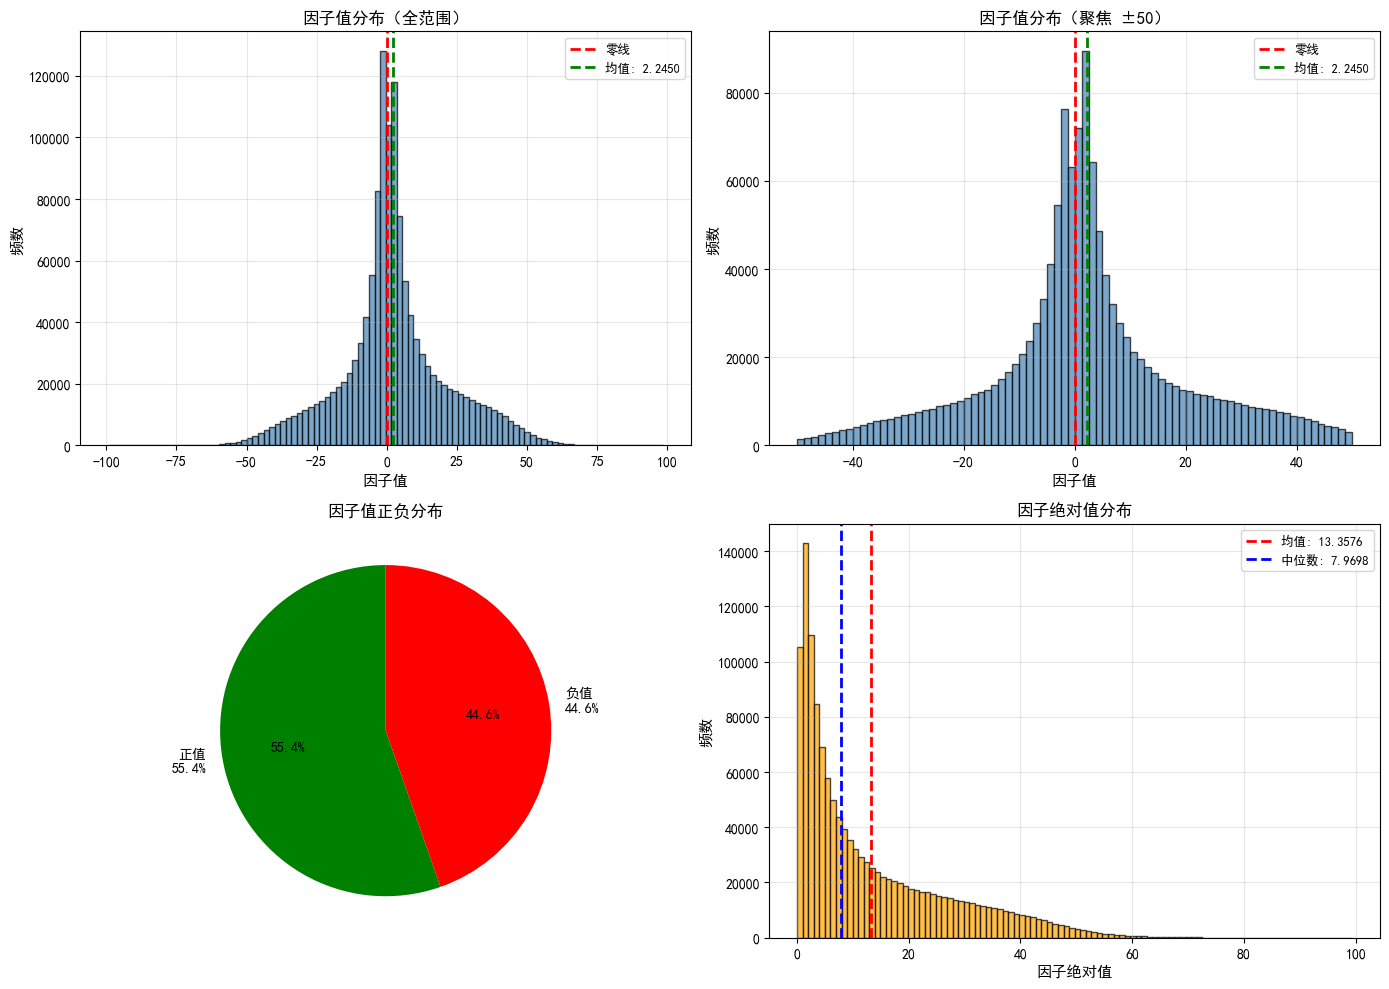

In [5]:
# 可视化因子值分布
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 重新计算统计（确保变量可用）
valid_vals = x_adx_vals.dropna()
abs_vals = x_adx_vals.abs().dropna()
valid_count = len(valid_vals)
positive_count = (valid_vals > 0).sum()
negative_count = (valid_vals < 0).sum()
zero_count = (valid_vals == 0).sum()

# 1. 因子值分布直方图（包含正负值）
axes[0, 0].hist(valid_vals, bins=100, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 0].axvline(0, color='red', linestyle='--', linewidth=2, label='零线')
axes[0, 0].axvline(valid_vals.mean(), color='green', linestyle='--', linewidth=2, 
                   label=f'均值: {valid_vals.mean():.4f}')
axes[0, 0].set_xlabel('因子值', fontsize=11)
axes[0, 0].set_ylabel('频数', fontsize=11)
axes[0, 0].set_title('因子值分布（全范围）', fontsize=12, fontweight='bold')
axes[0, 0].legend(fontsize=9)
axes[0, 0].grid(True, alpha=0.3)

# 2. 因子值分布直方图（聚焦中心区域，±50）
valid_vals_centered = valid_vals[(valid_vals >= -50) & (valid_vals <= 50)]
if len(valid_vals_centered) > 0:
    axes[0, 1].hist(valid_vals_centered, bins=80, edgecolor='black', alpha=0.7, color='steelblue')
    axes[0, 1].axvline(0, color='red', linestyle='--', linewidth=2, label='零线')
    axes[0, 1].axvline(valid_vals.mean(), color='green', linestyle='--', linewidth=2, 
                       label=f'均值: {valid_vals.mean():.4f}')
axes[0, 1].set_xlabel('因子值', fontsize=11)
axes[0, 1].set_ylabel('频数', fontsize=11)
axes[0, 1].set_title('因子值分布（聚焦 ±50）', fontsize=12, fontweight='bold')
axes[0, 1].legend(fontsize=9)
axes[0, 1].grid(True, alpha=0.3)

# 3. 正负值比例饼图
positive_pct = positive_count / valid_count * 100
negative_pct = negative_count / valid_count * 100
zero_pct = zero_count / valid_count * 100

labels = [f'正值\n{positive_pct:.1f}%', f'负值\n{negative_pct:.1f}%']
if zero_pct > 0.1:
    labels.append(f'零值\n{zero_pct:.1f}%')
    sizes = [positive_pct, negative_pct, zero_pct]
    colors = ['green', 'red', 'gray']
else:
    sizes = [positive_pct, negative_pct]
    colors = ['green', 'red']

axes[1, 0].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', 
               startangle=90, textprops={'fontsize': 10})
axes[1, 0].set_title('因子值正负分布', fontsize=12, fontweight='bold')

# 4. 绝对值分布直方图
axes[1, 1].hist(abs_vals, bins=100, edgecolor='black', alpha=0.7, color='orange')
axes[1, 1].axvline(abs_vals.mean(), color='red', linestyle='--', linewidth=2, 
                   label=f'均值: {abs_vals.mean():.4f}')
axes[1, 1].axvline(abs_vals.median(), color='blue', linestyle='--', linewidth=2, 
                   label=f'中位数: {abs_vals.median():.4f}')
axes[1, 1].set_xlabel('因子绝对值', fontsize=11)
axes[1, 1].set_ylabel('频数', fontsize=11)
axes[1, 1].set_title('因子绝对值分布', fontsize=12, fontweight='bold')
axes[1, 1].legend(fontsize=9)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 步骤 4: 运行回测


In [6]:
# 加载回测配置
backtest_config = load_backtest_config()
costs_config = load_costs_config()

print("=" * 60)
print("回测配置")
print("=" * 60)
print(f"window_size: {backtest_config.get('window_size', 1)}")
print(f"booksize: {backtest_config.get('booksize', 1.0)}")
print(f"upper_bound: {backtest_config.get('upper_bound', 0.1)}")
print("=" * 60)

# 运行回测
print(f"\n运行回测 (window_size={backtest_config.get('window_size', 1)})...")
bt_results = simulate_portfolio(
    alpha=factor_normalized,  # 传入归一化后的因子值（原始信号）
    prices=data['close'],
    volume=data['volume'],
    costs=costs_config,
    booksize=backtest_config.get('booksize', 1.0),
    upper_bound=backtest_config.get('upper_bound', 0.1),
    window_size=backtest_config.get('window_size', 1)
)

print("✓ 回测完成")
print(f"日期范围: {bt_results.index.min()} 到 {bt_results.index.max()}")
print(f"\n回测结果概览:")
print(bt_results.describe())


回测配置
window_size: 14
booksize: 1.0
upper_bound: 0.1

运行回测 (window_size=14)...
✓ 回测完成
日期范围: 2015-01-02 00:00:00-05:00 到 2025-12-26 00:00:00-05:00

回测结果概览:
               ret      ret_net          tvr     dailypnl  dailypnl_net  \
count  2763.000000  2763.000000  2763.000000  2763.000000   2763.000000   
mean      0.000567     0.000457     0.073323     0.000567      0.000457   
std       0.010395     0.010390     0.042743     0.010395      0.010390   
min      -0.095204    -0.095421     0.000000    -0.095204     -0.095421   
25%      -0.004099    -0.004179     0.054775    -0.004099     -0.004179   
50%       0.000801     0.000696     0.065430     0.000801      0.000696   
75%       0.005573     0.005478     0.078145     0.005573      0.005478   
max       0.074536     0.074231     1.000000     0.074536      0.074231   

         long_size  
count  2763.000000  
mean      0.990228  
std       0.098387  
min       0.000000  
25%       1.000000  
50%       1.000000  
75%       1.000000  
ma

In [7]:
# 只保留第8和第9组（Q8和Q9）的因子值
print("=" * 60)
print("因子过滤：仅保留 Q8 和 Q9")
print("=" * 60)

# 创建过滤后的因子 DataFrame
factor_filtered = pd.DataFrame(index=factor_normalized.index, 
                               columns=factor_normalized.columns,
                               dtype=float)

# 按日期分组，每日对因子值进行分位数分组
for date in factor_normalized.index:
    factor_row = factor_normalized.loc[date]
    
    # 去除缺失值
    valid_mask = ~factor_row.isna()
    if valid_mask.sum() < 10:  # 至少需要10个有效值才能分10组
        factor_filtered.loc[date] = np.nan
        continue
    
    factor_valid = factor_row[valid_mask]
    
    # 使用 qcut 分成10组
    try:
        quantiles = pd.qcut(factor_valid, q=10, labels=False, duplicates='drop') + 1
    except ValueError:
        # 如果无法分成10组，跳过这一天
        factor_filtered.loc[date] = np.nan
        continue
    
    # 只保留 Q8 和 Q9 的因子值，其他设为 NaN
    mask_q8_q9 = (quantiles == 8) | (quantiles == 9)
    filtered_row = factor_row.copy()
    filtered_row[~mask_q8_q9] = np.nan
    
    factor_filtered.loc[date] = filtered_row

# 统计过滤后的结果
total_before = (~factor_normalized.isna()).sum().sum()
total_after = (~factor_filtered.isna()).sum().sum()
retention_rate = total_after / total_before * 100 if total_before > 0 else 0

print(f"过滤前有效因子值数量: {total_before:,}")
print(f"过滤后有效因子值数量: {total_after:,}")
print(f"保留比例: {retention_rate:.2f}%")
print("=" * 60)

# 使用过滤后的因子进行后续回测
factor_for_backtest = factor_filtered


因子过滤：仅保留 Q8 和 Q9


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

## 步骤 5: 运行回测（仅 Q8 和 Q9）


## 步骤 5: 计算性能指标


In [8]:
# 计算性能指标（使用费后收益率，包含 CAPM 指标）
# 使用合成基准（等权重组合）消除幸存者偏差
metrics = calculate_metrics(
    bt_results['ret_net'], 
    risk_free_rate=0.0,
    benchmark_returns=synthetic_benchmark
)

print("=" * 60)
print("回测性能指标")
print("=" * 60)
print(f"算术年化收益率: {metrics['annual_return_arithmetic']*100:.2f}%")
print(f"几何年化收益率: {metrics['annual_return_geometric']*100:.2f}%")
print(f"年化波动率: {metrics['annual_volatility']*100:.2f}%")
print(f"夏普比率: {metrics['sharpe_ratio']:.4f}")
print(f"累计收益率: {metrics['cumulative_return']*100:.2f}%")
print(f"最大回撤: {metrics['max_drawdown']*100:.2f}%")
print(f"最大回撤持续时间: {metrics['max_drawdown_duration']} 天")
print(f"胜率: {metrics['win_rate']*100:.2f}%")
print(f"盈亏比: {metrics['profit_loss_ratio']:.4f}")
print(f"总交易天数: {metrics['total_trades']}")
print(f"盈利天数: {metrics['positive_trades']}")
print(f"亏损天数: {metrics['negative_trades']}")

# CAPM 指标（相对合成基准 - 等权重组合）
if not pd.isna(metrics['alpha']):
    print("\n" + "-" * 60)
    print("CAPM 指标 (相对合成基准 - 等权重组合)")
    print("-" * 60)
    print(f"Alpha (年化): {metrics['alpha']*100:.2f}%")
    print(f"Beta: {metrics['beta']:.4f}")
    print(f"R-Squared: {metrics['r_squared']:.4f}")
    print("\n说明: 合成基准基于当前股票池构建，消除了幸存者偏差")
else:
    print("\n" + "-" * 60)
    print("CAPM 指标: 未计算（缺少基准数据）")
    print("-" * 60)

print("=" * 60)

# 平均换手率
avg_tvr = bt_results['tvr'].mean()
print(f"\n平均换手率: {avg_tvr*100:.2f}%")


回测性能指标
算术年化收益率: 11.52%
几何年化收益率: 10.68%
年化波动率: 16.49%
夏普比率: 0.6477
累计收益率: 204.31%
最大回撤: -33.21%
最大回撤持续时间: 491 天
胜率: 54.58%
盈亏比: 0.9283
总交易天数: 2763
盈利天数: 1508
亏损天数: 1228

------------------------------------------------------------
CAPM 指标 (相对合成基准 - 等权重组合)
------------------------------------------------------------
Alpha (年化): -2.39%
Beta: 0.8378
R-Squared: 0.8677

说明: 合成基准基于当前股票池构建，消除了幸存者偏差

平均换手率: 7.33%


## 步骤 6: 可视化结果


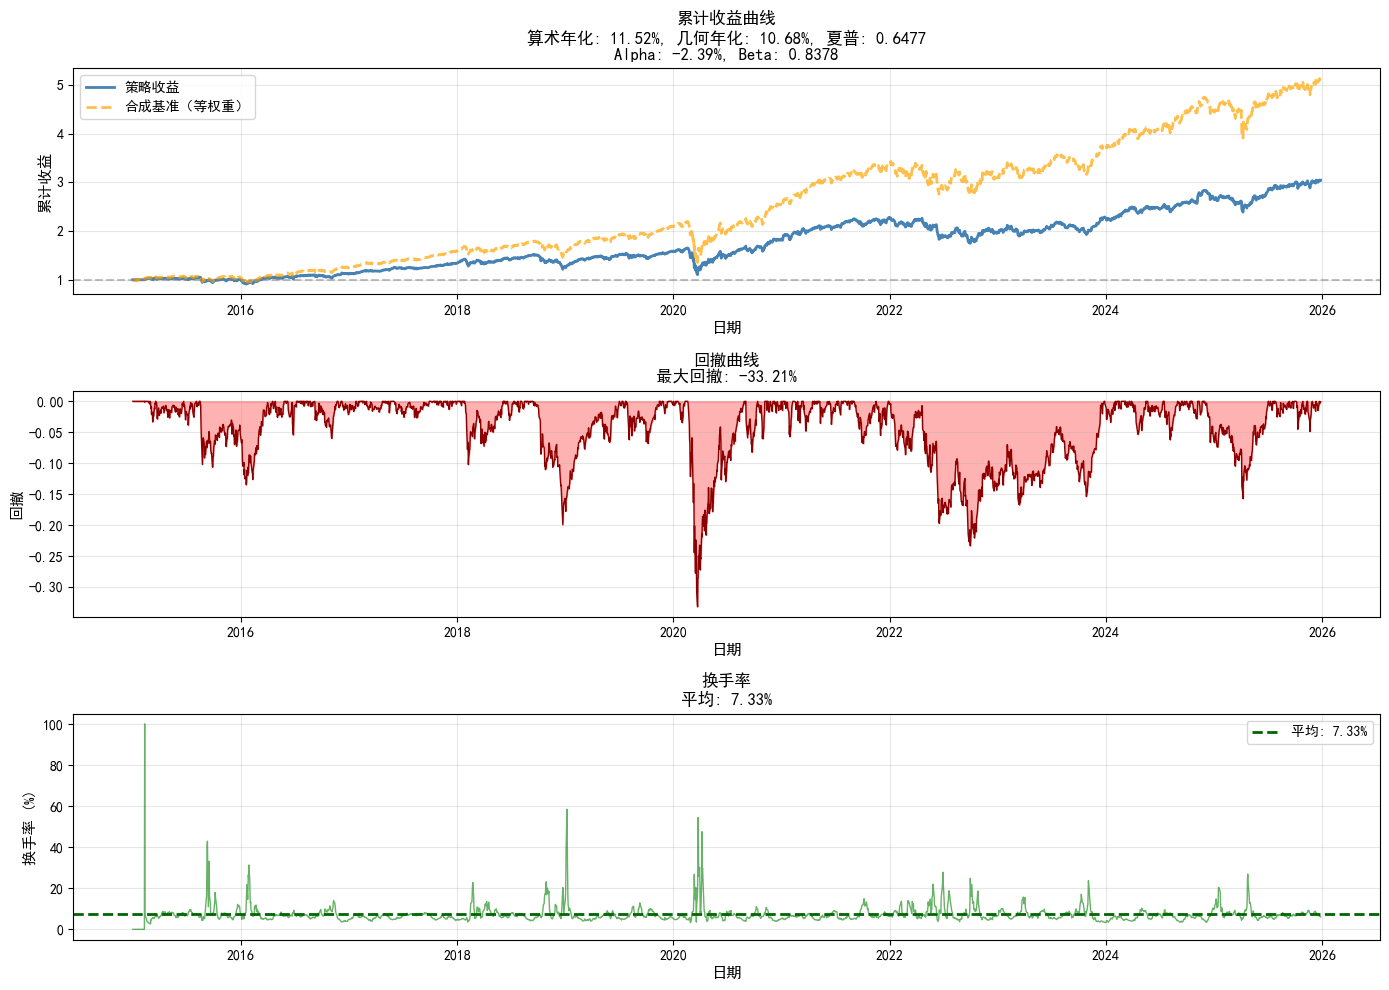

In [9]:
# 绘制累计收益曲线
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# 1. 累计收益曲线
cumulative_ret = (1 + bt_results['ret_net']).cumprod()
axes[0].plot(cumulative_ret.index, cumulative_ret.values, linewidth=2, color='steelblue', label='策略收益')

# 绘制合成基准收益曲线（等权重组合）
common_dates = cumulative_ret.index.intersection(synthetic_benchmark.index)
if len(common_dates) > 0:
    benchmark_cumulative = (1 + synthetic_benchmark.loc[common_dates]).cumprod()
    axes[0].plot(benchmark_cumulative.index, benchmark_cumulative.values, 
                 linewidth=2, color='orange', linestyle='--', alpha=0.7, label='合成基准（等权重）')
    axes[0].legend(fontsize=10)

title = f'累计收益曲线\n算术年化: {metrics["annual_return_arithmetic"]*100:.2f}%, 几何年化: {metrics["annual_return_geometric"]*100:.2f}%, 夏普: {metrics["sharpe_ratio"]:.4f}'
if not pd.isna(metrics['alpha']):
    title += f'\nAlpha: {metrics["alpha"]*100:.2f}%, Beta: {metrics["beta"]:.4f}'
axes[0].set_title(title, fontsize=12, fontweight='bold')
axes[0].set_xlabel('日期', fontsize=11)
axes[0].set_ylabel('累计收益', fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].axhline(1, color='gray', linestyle='--', alpha=0.5)

# 2. 回撤曲线
cumulative = (1 + bt_results['ret_net']).cumprod()
running_max = cumulative.expanding().max()
drawdown = (cumulative - running_max) / running_max
axes[1].fill_between(drawdown.index, drawdown.values, 0, color='red', alpha=0.3)
axes[1].plot(drawdown.index, drawdown.values, linewidth=1, color='darkred')
axes[1].set_title(f'回撤曲线\n最大回撤: {metrics["max_drawdown"]*100:.2f}%', 
                  fontsize=12, fontweight='bold')
axes[1].set_xlabel('日期', fontsize=11)
axes[1].set_ylabel('回撤', fontsize=11)
axes[1].grid(True, alpha=0.3)

# 3. 换手率
axes[2].plot(bt_results['tvr'].index, bt_results['tvr'].values * 100, linewidth=1, color='green', alpha=0.6)
axes[2].axhline(avg_tvr * 100, color='darkgreen', linestyle='--', linewidth=2, label=f'平均: {avg_tvr*100:.2f}%')
axes[2].set_title(f'换手率\n平均: {avg_tvr*100:.2f}%', 
                  fontsize=12, fontweight='bold')
axes[2].set_xlabel('日期', fontsize=11)
axes[2].set_ylabel('换手率 (%)', fontsize=11)
axes[2].legend(fontsize=10)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 步骤 7: 因子 IC 和 IR 分析


计算因子 IC 和 IR...

因子 IC 和 IR 统计
IC 均值: -0.0058
IC 标准差: 0.1416
IR (信息比率): -0.0410
IC 正比例: 49.32%
有效观测数: 2735

绘制 IC 分布和时间序列...


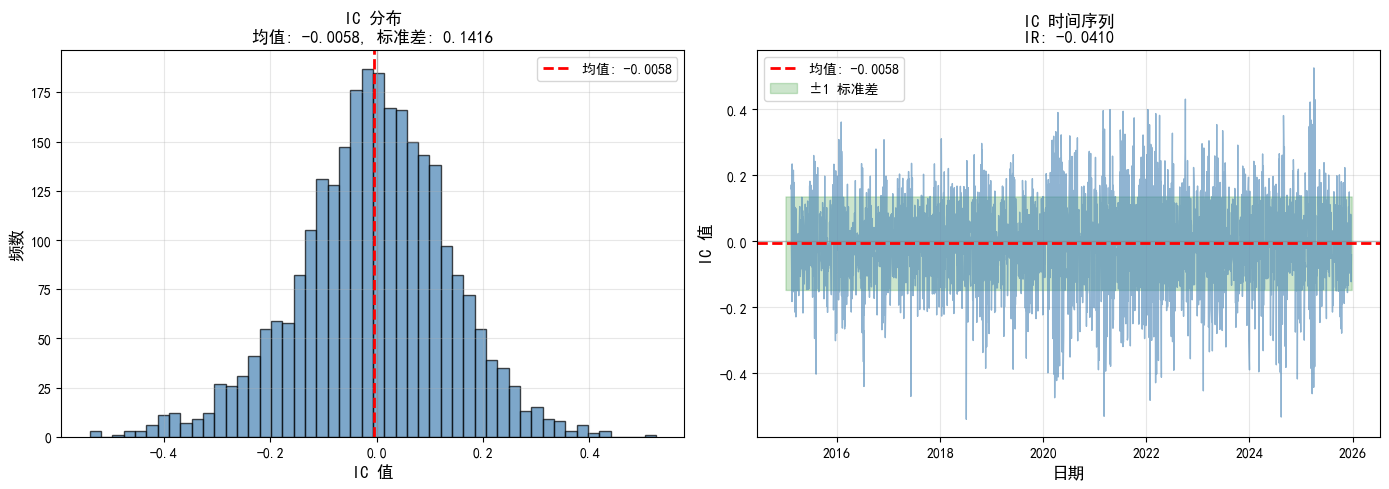

In [10]:
# 计算因子 IC（Information Coefficient）和 IR（Information Ratio）
print("计算因子 IC 和 IR...")

# 计算未来收益率（使用下一天的收益率）
forward_returns = data['close'].pct_change().shift(-1)

# 计算 IC（每日因子值与未来收益率的相关系数）
ic_series = calculate_ic(
    factor_values=factor_values,
    forward_returns=forward_returns,
    method='pearson'  # 使用皮尔逊相关系数
)

# 计算 IR（Information Ratio = IC均值 / IC标准差）
ir = calculate_ir(ic_series)

# 计算 IC 统计
ic_mean = ic_series.mean()
ic_std = ic_series.std()
ic_positive_ratio = (ic_series > 0).sum() / len(ic_series.dropna())

print("\n" + "=" * 60)
print("因子 IC 和 IR 统计")
print("=" * 60)
print(f"IC 均值: {ic_mean:.4f}")
print(f"IC 标准差: {ic_std:.4f}")
print(f"IR (信息比率): {ir:.4f}")
print(f"IC 正比例: {ic_positive_ratio*100:.2f}%")
print(f"有效观测数: {len(ic_series.dropna())}")
print("=" * 60)

# 绘制 IC 分布和时间序列
print("\n绘制 IC 分布和时间序列...")
plot_ic_distribution(ic_series)


## 步骤 8: 因子分位数分析


In [ ]:
# 因子分位数分析（10组）
print("计算因子分位数收益（10组）...")

# 使用 factor_returns_by_quantile 计算分位数收益
quantile_returns = factor_returns_by_quantile(
    factor_values=factor_values,
    forward_returns=data['close'].pct_change(),
    n_quantiles=10
)

# 计算年化收益（每日收益 * 252）
quantile_annual_returns = quantile_returns.mean() * 252

# 计算多空收益（最高分位 - 最低分位）
long_short_return = quantile_annual_returns.iloc[-1] - quantile_annual_returns.iloc[0]

print("\n" + "=" * 60)
print("因子分位数年化收益（10组）")
print("=" * 60)
for q in range(1, 11):
    if q in quantile_annual_returns.index:
        print(f"Q{q}: {quantile_annual_returns[q]*100:.2f}%")

print(f"\n多空收益 (Q10-Q1): {long_short_return*100:.2f}%")
print("=" * 60)


In [ ]:
# 可视化因子分位数收益
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. 分位数年化收益柱状图
quantile_values = [quantile_annual_returns[q]*100 if q in quantile_annual_returns.index else 0 for q in range(1, 11)]

colors = ['red' if v < 0 else 'green' for v in quantile_values]
axes[0].bar(range(10), quantile_values, color=colors, alpha=0.7, edgecolor='black')
axes[0].set_title('X-ADX 因子分位数年化收益（10组）', fontsize=14, fontweight='bold')
axes[0].set_xlabel('分位数组', fontsize=12)
axes[0].set_ylabel('年化收益率 (%)', fontsize=12)
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_xticks(range(10))
axes[0].set_xticklabels([f'Q{i+1}' for i in range(10)])
axes[0].axhline(0, color='black', linestyle='-', linewidth=0.5)

# 2. 分位数累计收益曲线
for q in range(1, 11):
    if q in quantile_returns.columns:
        cumulative = (1 + quantile_returns[q]).cumprod()
        axes[1].plot(cumulative.index, cumulative.values, 
                    label=f'Q{q}', linewidth=1.5, alpha=0.7)

axes[1].set_title('X-ADX 因子分位数累计收益曲线', fontsize=14, fontweight='bold')
axes[1].set_xlabel('日期', fontsize=12)
axes[1].set_ylabel('累计收益', fontsize=12)
axes[1].legend(loc='best', fontsize=9, ncol=2)
axes[1].grid(True, alpha=0.3)
axes[1].axhline(1, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# 打印关键统计
print("\n关键统计:")
print(f"  最高分位 (Q10) 年化收益: {quantile_annual_returns.iloc[-1]*100:.2f}%")
print(f"  最低分位 (Q1) 年化收益: {quantile_annual_returns.iloc[0]*100:.2f}%")
print(f"  多空收益 (Q10-Q1): {long_short_return*100:.2f}%")
